<a href="https://colab.research.google.com/github/shettyani-rudh/Authentication_With_Clerk/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import wget
import zipfile
import os

# The direct download link you found for the WESAD dataset.
# The '/download' at the end tells the server to give us the file directly.
url = "https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download"

# Check if the dataset is already downloaded
if not os.path.exists('WESAD.zip'):
    print("Downloading WESAD dataset using the new link...")
    # We tell wget to download from your URL and save the file as 'WESAD.zip'
    wget.download(url, 'WESAD.zip')
    print("\nDownload complete.")
else:
    print("WESAD.zip already exists.")

# Unzip the file
if not os.path.exists('WESAD'):
    print("Unzipping WESAD.zip...")
    with zipfile.ZipFile('WESAD.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Unzipping complete.")
else:
    print("WESAD directory already exists.")


Download complete.
Unzipping WESAD.zip...
Unzipping complete.


In [ ]:
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk

def load_subject_data(subject_id):
    """
    Loads the WESAD data for a single subject from the pickle file.
    """
    # We construct the file path using the subject's ID.
    file_path = f'WESAD/S{subject_id}/S{subject_id}.pkl'

    # 'rb' means we're reading the file in binary mode, which is required for pickle files.
    with open(file_path, 'rb') as file:
        # pickle.load() reads the file back into a Python object (a dictionary here).
        data = pickle.load(file, encoding='latin1')
    return data

# --- Let's load the data for Subject 2 ---
subject_data = load_subject_data(2)

# The data is a dictionary. Let's inspect its main keys.
print("Keys in the data file:", subject_data.keys())

# --- Now, let's extract the specific signals we need ---
# We navigate the dictionary to get to the chest-worn device signals.
chest_signals = subject_data['signal']['chest']
# The ECG signal is one of the sensors in the 'chest' dictionary.
ecg_signal = chest_signals['ECG']
# The labels tell us the emotional state at each point in time.
labels = subject_data['label']

# The sampling rate for the chest sensors in WESAD is 700 Hz.
sampling_rate = 700

print(f"\nSuccessfully loaded data for Subject 2.")
print(f"The ECG signal has {len(ecg_signal)} data points.")
print(f"The labels array has {len(labels)} entries.")

Keys in the data file: dict_keys(['signal', 'label', 'subject'])

Successfully loaded data for Subject 2.
The ECG signal has 4255300 data points.
The labels array has 4255300 entries.


In [ ]:
def extract_features_for_subject(subject_id, window_size_sec=30, sampling_rate=700):
    """
    Extracts HRV features from a subject's ECG signal using a sliding window.

    Args:
        subject_id (int): The ID of the subject to process.
        window_size_sec (int): The size of the sliding window in seconds.
        sampling_rate (int): The sampling rate of the ECG signal.

    Returns:
        pandas.DataFrame: A DataFrame where each row is a 30-second window
                          and each column is a calculated feature.
    """
    print(f"--- Starting feature extraction for Subject {subject_id} ---")

    # Load the subject's data using the function from the previous step.
    data = load_subject_data(subject_id)
    ecg_signal = data['signal']['chest']['ECG'].ravel() # .ravel() ensures it's a 1D array
    labels = data['label']

    # Calculate the number of data points in each window.
    window_size_samples = window_size_sec * sampling_rate

    all_features = []

    # Slide the window across the entire signal.
    # The step size is equal to the window size, so the windows don't overlap.
    for i in range(0, len(ecg_signal) - window_size_samples, window_size_samples):
        window_start = i
        window_end = i + window_size_samples

        ecg_window = ecg_signal[window_start:window_end]
        label_window = labels[window_start:window_end]

        # To get a single label for the window, we find the most frequent one (the mode).
        dominant_label = np.bincount(label_window).argmax()

        # We only care about baseline (1 -> No Stress) and stress (2 -> Stress) states.
        # We ignore transient phases (0) or other activities like amusement (3).
        if dominant_label in [1, 2]:
            try:
                # Use NeuroKit2 to find the R-peaks in the ECG signal.
                _, rpeaks = nk.ecg_peaks(ecg_window, sampling_rate=sampling_rate)

                # If we find at least 2 peaks, we can calculate HRV.
                if rpeaks['ECG_R_Peaks'].size > 2:
                    # Calculate all the available HRV features.
                    hrv_features = nk.hrv(rpeaks, sampling_rate=sampling_rate, show=False)

                    # Add our own label column to the features.
                    hrv_features['label'] = 'Stress' if dominant_label == 2 else 'No Stress'

                    all_features.append(hrv_features)
            except Exception as e:
                # Sometimes a window is too noisy to process. We'll just skip it.
                # print(f"Skipping a window for S{subject_id} due to error: {e}")
                pass

    if not all_features:
        print(f"No valid windows found for Subject {subject_id}.")
        return pd.DataFrame()

    # Combine the features from all windows into a single DataFrame.
    subject_features_df = pd.concat(all_features, ignore_index=True)
    print(f"--- Finished feature extraction for Subject {subject_id} ---")
    print(f"    Extracted features for {len(subject_features_df)} windows.\n")

    return subject_features_df

# --- Let's test the function on Subject 2 ---
subject_2_features = extract_features_for_subject(2)

# Display the first 5 rows of our new features table.
print("Preview of the extracted features:")
display(subject_2_features.head())

--- Starting feature extraction for Subject 2 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 2 ---
    Extracted features for 58 windows.

Preview of the extracted features:


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,label
0,733.357143,84.167702,NaN,NaN,NaN,NaN,NaN,NaN,39.454682,39.895344,...,5.171928,0.805504,0.0,0.525912,0.526469,1.346261,1.457699,2.266352,0.665241,No Stress
1,755.187970,129.027258,NaN,NaN,NaN,NaN,NaN,NaN,142.997807,144.897929,...,5.037401,1.004104,0.0,0.000000,0.000000,1.652645,1.652644,2.692429,0.828620,No Stress
2,828.000000,56.506116,NaN,NaN,NaN,NaN,NaN,NaN,47.665803,48.352538,...,4.900712,1.340008,0.0,0.000000,0.000000,2.373919,1.798507,2.785684,1.318958,No Stress
3,867.575758,85.393361,NaN,NaN,NaN,NaN,NaN,NaN,56.321666,57.203291,...,4.635007,0.980138,0.0,0.000000,0.000000,1.960396,1.708790,1.933842,0.917163,No Stress
4,842.773109,60.318615,NaN,NaN,NaN,NaN,NaN,NaN,69.954044,70.962113,...,4.852169,1.313037,0.0,0.000000,0.000000,2.133058,1.828605,2.334943,1.197050,No Stress


HRV_MeanNN: This is simply the average time between heartbeats. It's directly related to your average heart rate.

HRV_SDNN: This stands for the Standard Deviation of NN intervals. It measures the total, overall amount of variability in the heartbeat timing. A higher number generally means more variability.

HRV_RMSSD: This is the Root Mean Square of Successive Differences. It's a key metric that specifically measures the short-term, beat-to-beat changes. It's strongly linked to the part of your nervous system that handles relaxation (the parasympathetic system).

Of course. These are the Heart Rate Variability (HRV) features that NeuroKit2 calculated for us. They are different statistical methods to measure the variation in time between your heartbeats.

Think of it this way: a healthy heart isn't a perfect metronome that ticks at a constant rhythm. It's constantly making tiny adjustments. HRV measures how much it's adjusting. High variability is often a sign of a healthy, adaptable nervous system, while low variability (more like a metronome) can be a sign of stress.

Here’s a breakdown of some of the most important ones you listed:

Time-Domain Features (The Basics) 📊
These are the most common and direct statistical measures of the time between beats (called "NN" or "R-R" intervals).

HRV_MeanNN: This is simply the average time between heartbeats. It's directly related to your average heart rate.

HRV_SDNN: This stands for the Standard Deviation of NN intervals. It measures the total, overall amount of variability in the heartbeat timing. A higher number generally means more variability.

HRV_RMSSD: This is the Root Mean Square of Successive Differences. It's a key metric that specifically measures the short-term, beat-to-beat changes. It's strongly linked to the part of your nervous system that handles relaxation (the parasympathetic system).

Non-Linear Features (The Advanced Stuff) 🧠
These are more complex metrics that measure the "unpredictability" and "complexity" of your heart rhythm.

HRV_ShanEn (Shannon Entropy): This measures the amount of regularity or predictability in your heart rhythm. A more complex, unpredictable pattern has higher entropy.

HRV_FuzzyEn (Fuzzy Entropy): Similar to Shannon Entropy, this also measures the predictability of the signal but is more robust to noise.

HRV_HFD / KFD / CD (Fractal Dimension): These features measure the "roughness" or "complexity" of the heartbeat pattern over time.

In [ ]:
import numpy as np
import pandas as pd

# The WESAD dataset includes subjects S2 through S17.
subject_ids = list(range(2, 18))
subject_ids.remove(8)
subject_ids.remove(11)
subject_ids.remove(12) # Exclude S12 as it's missing

# --- Process all subjects and combine their data ---
all_subjects_features = []
for sid in subject_ids:
    subject_features = extract_features_for_subject(sid)
    if not subject_features.empty:
        all_subjects_features.append(subject_features)

# --- Combine all individual DataFrames into one master DataFrame ---
df = pd.concat(all_subjects_features, ignore_index=True)

# --- CORRECTED Final data cleaning ---

# Step 1: Replace all infinite values with NaN (Not a Number).
# This makes all our "bad" data consistent.
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Now, fill all NaN values with the median of their respective columns.
# The .fillna() function is specifically designed for this.
df.fillna(df.median(numeric_only=True), inplace=True)

print("\n--- MASTER DATASET CREATED AND CLEANED ---")
print(f"Total samples (windows): {df.shape[0]}")
print(f"Total features (columns): {df.shape[1] - 1}") # Subtract 1 for the 'label' column
print("Preview of the final combined dataset:")
display(df.head())

--- Starting feature extraction for Subject 2 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 2 ---
    Extracted features for 58 windows.

--- Starting feature extraction for Subject 3 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/usr/local/lib/python3.12/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/usr/local/lib/python3.12/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 relate

--- Finished feature extraction for Subject 3 ---
    Extracted features for 59 windows.

--- Starting feature extraction for Subject 4 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 4 ---
    Extracted features for 60 windows.

--- Starting feature extraction for Subject 5 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 5 ---
    Extracted features for 62 windows.

--- Starting feature extraction for Subject 6 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 6 ---
    Extracted features for 62 windows.

--- Starting feature extraction for Subject 7 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 7 ---
    Extracted features for 62 windows.

--- Starting feature extraction for Subject 9 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 9 ---
    Extracted features for 61 windows.

--- Starting feature extraction for Subject 10 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 10 ---
    Extracted features for 64 windows.

--- Starting feature extraction for Subject 13 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 13 ---
    Extracted features for 61 windows.

--- Starting feature extraction for Subject 14 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 14 ---
    Extracted features for 62 windows.

--- Starting feature extraction for Subject 15 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 15 ---
    Extracted features for 62 windows.

--- Starting feature extraction for Subject 16 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/usr/local/lib/python3.12/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value en

--- Finished feature extraction for Subject 16 ---
    Extracted features for 63 windows.

--- Starting feature extraction for Subject 17 ---


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in

--- Finished feature extraction for Subject 17 ---
    Extracted features for 63 windows.


--- MASTER DATASET CREATED AND CLEANED ---
Total samples (windows): 799
Total features (columns): 82
Preview of the final combined dataset:


/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/hrv/hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,label
0,733.357143,84.167702,NaN,NaN,NaN,NaN,NaN,NaN,39.454682,39.895344,...,5.171928,0.805504,0.0,0.525912,0.526469,1.346261,1.457699,2.266352,0.665241,No Stress
1,755.187970,129.027258,NaN,NaN,NaN,NaN,NaN,NaN,142.997807,144.897929,...,5.037401,1.004104,0.0,0.000000,0.000000,1.652645,1.652644,2.692429,0.828620,No Stress
2,828.000000,56.506116,NaN,NaN,NaN,NaN,NaN,NaN,47.665803,48.352538,...,4.900712,1.340008,0.0,0.000000,0.000000,2.373919,1.798507,2.785684,1.318958,No Stress
3,867.575758,85.393361,NaN,NaN,NaN,NaN,NaN,NaN,56.321666,57.203291,...,4.635007,0.980138,0.0,0.000000,0.000000,1.960396,1.708790,1.933842,0.917163,No Stress
4,842.773109,60.318615,NaN,NaN,NaN,NaN,NaN,NaN,69.954044,70.962113,...,4.852169,1.313037,0.0,0.000000,0.000000,2.133058,1.828605,2.334943,1.197050,No Stress


Step 1: Data Preparation
Dataset: We are using the publicly available WESAD (Wearable Stress and Affect Detection) dataset.

Process: The data was downloaded and unzipped directly within the Google Colab environment.

Subject Selection: We are using data from all available subjects except S12 (missing data) and S8 & S11 (known data quality issues) to ensure our model trains on reliable data.

Step 2: Data Loading
Signal Focus: We are exclusively using the ECG signal, which was recorded from a chest-worn device at a sampling rate of 700 Hz.

File Type: The data for each subject is loaded from a .pkl file, which contains all sensor signals synchronized with the experimental condition labels.

Step 3: Feature Extraction
Methodology: We used a 30-second sliding window approach to analyze the raw ECG signal in manageable chunks.

Tool: The NeuroKit2 library was used to perform complex physiological signal processing.

Features: For each 30-second window, we calculated a comprehensive set of Heart Rate Variability (HRV) features. These features statistically describe the variations in time between heartbeats.

Final Dataset: The features from all valid windows across all selected subjects were combined into a single master table (DataFrame). Any missing values (NaN) were filled with the median of their respective columns to create a clean dataset ready for machine learning.

Outcome: Our final dataset has 799 samples and 82 features.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# 1. Separate our data into features (X) and the target label (y)
X = df.drop('label', axis=1)
y = df['label']

# 2. Split the dataset into training (80%) and testing (20%) sets
# 'stratify=y' ensures both sets have a similar balance of 'Stress' and 'No Stress' samples.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

# 3. Initialize and train the Decision Tree classifier
# `max_depth=5` helps prevent the model from becoming too complex.
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)

print("\nTraining the model...")
# The .fit() method is where the model learns the patterns from the training data.
dt_classifier.fit(X_train, y_train)
print("Training complete!")

Training set has 639 samples.
Testing set has 160 samples.

Training the model...
Training complete!


--- Classification Report ---
              precision    recall  f1-score   support

   No Stress       0.86      0.90      0.88       102
      Stress       0.81      0.74      0.77        58

    accuracy                           0.84       160
   macro avg       0.84      0.82      0.83       160
weighted avg       0.84      0.84      0.84       160


--- Confusion Matrix ---


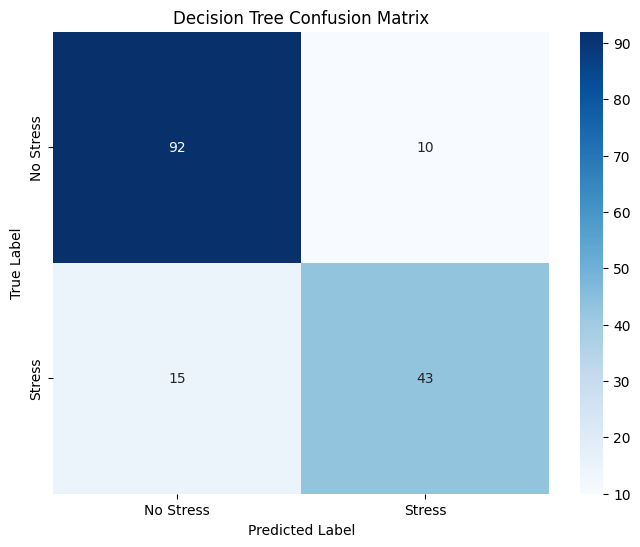

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Use the trained model to make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# 2. Generate and print the classification report
# This report breaks down the model's performance for each class ('Stress' and 'No Stress').
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 3. Generate and display the confusion matrix
# This gives us a visual breakdown of the predictions.
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred, labels=dt_classifier.classes_)
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_classifier.classes_,
            yticklabels=dt_classifier.classes_)
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Model Evaluation Results
The model was evaluated on the unseen test set, which contained 160 samples. The results indicate a strong and reliable performance.

Overall Performance
Accuracy: The model achieved an overall accuracy of 84%, meaning it correctly predicted the state (Stress or No Stress) for 135 out of the 160 test samples.

Classification Report Insights
The performance for each class was as follows:

"No Stress" Class:

Precision: 86% - When the model predicted "No Stress," it was correct 86% of the time.

Recall: 90% - The model successfully identified 90% of all actual "No Stress" instances.

"Stress" Class:

Precision: 81% - When the model predicted "Stress," it was correct 81% of the time.

Recall: 74% - The model successfully identified 74% of all actual "Stress" instances.

Confusion Matrix Analysis
The confusion matrix provides a visual breakdown of the model's predictions:

Correct Predictions:

True Negatives: 92 - Correctly identified "No Stress."

True Positives: 43 - Correctly identified "Stress."

Incorrect Predictions:

False Negatives: 15 - The model failed to detect stress when it was actually present. This is the most critical error to monitor.

False Positives: 10 - The model incorrectly predicted "Stress" during a non-stress period (a "false alarm").



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy the WESAD.zip file to your Google Drive
# Make sure you have already downloaded it in this session
!cp WESAD.zip /content/drive/MyDrive/

In [ ]:
import joblib

# 1. Define a path and filename in your Google Drive
model_path = '/content/drive/MyDrive/decision_tree_stress_model.joblib'

# 2. Save the trained model object to that path
joblib.dump(dt_classifier, model_path)

print(f"Model saved successfully to: {model_path}")

Model saved successfully to: /content/drive/MyDrive/decision_tree_stress_model.joblib
